In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gdp-of-all-countries19602020/gdp_1960_2020.csv


 # 1. Reading the data

In [2]:
all_gdp_df = pd.read_csv("/kaggle/input/gdp-of-all-countries19602020/gdp_1960_2020.csv");
all_gdp_df[:10]

,year,rank,country,state,gdp,gdp_percent
0,1960,1,the United States,America,543300000000,0.468483
1,1960,2,United Kingdom,Europe,73233967692,0.063149
2,1960,3,France,Europe,62225478000,0.053656
3,1960,4,China,Asia,59716467625,0.051493
4,1960,5,Japan,Asia,44307342950,0.038206
5,1960,6,Canada,America,40461721692,0.034890
6,1960,7,Italy,Europe,40385288344,0.034824
7,1960,8,India,Asia,37029883875,0.031931
8,1960,9,Australia,Oceania,18577668271,0.016019
9,1960,10,Sweden,Europe,15822585033,0.013644


 # 2. **Checking the consistency of country over years.**

In [3]:
count_in_each_year = pd.Series(all_gdp_df.groupby('year')['gdp'].count())
print(count_in_each_year)
# so the number of countries in each year is inconsistent.
print(count_in_each_year.min())


year
1960    103
1961    103
1962    105
1963    105
1964    105
       ... 
2016    205
2017    204
2018    204
2019    199
2020    175
Name: gdp, Length: 61, dtype: int64
103


# Years with minimum number of countries.

In [4]:
#where gives Nan in the places where the conditions don't match. So, we use dropna().
print(count_in_each_year.where(count_in_each_year==103).dropna())

year
1960    103.0
1961    103.0
Name: gdp, dtype: float64


**Checking if these two years have same countries.**

In [5]:
filter1 = all_gdp_df['year']==1960
nations_1960 = pd.Series(all_gdp_df.where(filter1).dropna()['country'])
filter2 = all_gdp_df['year']==1961
nations_1961 = pd.Series(all_gdp_df.where(filter2).dropna()['country'])
print(nations_1961)
#the new series for 1961 is being indexed starting from 103. Need to reset it.

103                   the United States
104                      United Kingdom
105                              France
106                               Japan
107                               China
                     ...               
201                            Botswana
202                              Belize
203    Saint Vincent and the Grenadines
204               Saint Kitts and Nevis
205                          Seychelles
Name: country, Length: 103, dtype: object


**Check for similarity**

In [6]:
#resetting the index of 1961 series.
nations_1961 = nations_1961.reset_index(drop = True)
nations_1960.compare(nations_1961)
#need to sort the country names
nations_1960_sorted = pd.Series(nations_1960.sort_values(ignore_index=True))
nations_1961_sorted = pd.Series(nations_1961.sort_values(ignore_index=True))
nations_1960_sorted.compare(nations_1961_sorted)
#so the countries in 1960 and 1961 are all same. 

,self,other


**For data consistency, I'll try to take these 103 countries only in other years too.**

In [7]:

#checking merging (join) query for two years.
#using astype(object) because where() upcasted the gdp to float representation(precision got lost).
nations_1965 = pd.DataFrame(all_gdp_df.where(all_gdp_df.year==1980).astype('O').dropna()["country"])
nations_1960 = all_gdp_df.where(all_gdp_df.year==1960).astype('O').dropna()
merged = pd.merge(nations_1965, nations_1960, on=['country'], how='inner')

test_joined = nations_1960.join(nations_1965.set_index('country'), how='inner',lsuffix="_x", on='country')
test_filtered =  test_joined[['year', 'rank', 'country', 'state', 'gdp', 'gdp_percent']].copy()
test_summed = nations_1960.append(test_filtered)
test_summed.count()


year           206
rank           206
country        206
state          206
gdp            206
gdp_percent    206
dtype: int64

**It turns out the number of common countries is even less than 103. So, Getting the common set of countries in all years.**

In [8]:
filtered_countries = pd.DataFrame(all_gdp_df.where(all_gdp_df.year==1960).dropna()["country"])
#initializing empty df for storing all year's filtered dfs.
common_countries = pd.DataFrame(columns=['country'])
for year, count in count_in_each_year.items():
    #get the dfs for each year
    countries_in_year = pd.DataFrame(all_gdp_df.where(all_gdp_df.year==year).dropna()["country"])
    #deduplicating the countries in each year.
    countries_in_year.drop_duplicates(subset=['country'], inplace=True)
    #join the dfs with 1960 year by ''country''
    right_suffix = '_'+ str(year)
    joined = countries_in_year.join(filtered_countries.set_index('country'), rsuffix=right_suffix, on='country', how='inner')
    #join returns columns of both left and right tables, so copying only the left columns.
    filtered_countries =  joined[['country']].copy()
    print('count in year: ', year, ' = ',filtered_countries['country'].count() )


count in year:  1960  =  103
count in year:  1961  =  103
count in year:  1962  =  103
count in year:  1963  =  103
count in year:  1964  =  103
count in year:  1965  =  102
count in year:  1966  =  102
count in year:  1967  =  102
count in year:  1968  =  102
count in year:  1969  =  102
count in year:  1970  =  102
count in year:  1971  =  102
count in year:  1972  =  102
count in year:  1973  =  102
count in year:  1974  =  102
count in year:  1975  =  101
count in year:  1976  =  101
count in year:  1977  =  101
count in year:  1978  =  101
count in year:  1979  =  101
count in year:  1980  =  101
count in year:  1981  =  101
count in year:  1982  =  100
count in year:  1983  =  100
count in year:  1984  =  100
count in year:  1985  =  100
count in year:  1986  =  100
count in year:  1987  =  100
count in year:  1988  =  100
count in year:  1989  =  100
count in year:  1990  =  100
count in year:  1991  =  98
count in year:  1992  =  98
count in year:  1993  =  98
count in year:  1

In [9]:
print(filtered_countries.count())
# gives 94 . so we have 94 countries which are available in all years!


country    94
dtype: int64


**Constructing a new dataframe using this list of countries and joining them with dfs of each country.**

In [10]:
#initializing empty df for storing all year's filtered dfs.
filtered_all_gdp_df = pd.DataFrame(columns=['year', 'rank', 'country', 'state', 'gdp', 'gdp_percent'])
for year, count in count_in_each_year.items():
    #get the dfs for each year
    df_for_year = all_gdp_df.where(all_gdp_df.year==year).dropna()
    #deduplicating the countries in each year's df.
    df_for_year.drop_duplicates(subset=['country'], inplace=True)
    #join the dfs with filtered_countries year by ''country''
    joined = df_for_year.join(filtered_countries.set_index('country'), rsuffix='_1960', on='country', how='inner')
    #join returns columns of both left and right tables, so copying only the left columns.
    filtered_df_for_year =  joined[['year', 'rank', 'country', 'state', 'gdp', 'gdp_percent']].copy()
    #appending dfs of each year to our initial empty df.
    filtered_all_gdp_df = filtered_all_gdp_df.append(filtered_df_for_year)
    print('count in year: ', year, ' = ',filtered_all_gdp_df['year'].count()/94)

    #AND FINALLY THE COUNTRIES IN EACH YEAR ARE CONSISTENT.

count in year:  1960  =  1.0
count in year:  1961  =  2.0
count in year:  1962  =  3.0
count in year:  1963  =  4.0
count in year:  1964  =  5.0
count in year:  1965  =  6.0
count in year:  1966  =  7.0
count in year:  1967  =  8.0
count in year:  1968  =  9.0
count in year:  1969  =  10.0
count in year:  1970  =  11.0
count in year:  1971  =  12.0
count in year:  1972  =  13.0
count in year:  1973  =  14.0
count in year:  1974  =  15.0
count in year:  1975  =  16.0
count in year:  1976  =  17.0
count in year:  1977  =  18.0
count in year:  1978  =  19.0
count in year:  1979  =  20.0
count in year:  1980  =  21.0
count in year:  1981  =  22.0
count in year:  1982  =  23.0
count in year:  1983  =  24.0
count in year:  1984  =  25.0
count in year:  1985  =  26.0
count in year:  1986  =  27.0
count in year:  1987  =  28.0
count in year:  1988  =  29.0
count in year:  1989  =  30.0
count in year:  1990  =  31.0
count in year:  1991  =  32.0
count in year:  1992  =  33.0
count in year:  199

In [11]:
#just checking if Nepal is included in these 103 countries.
filtered_all_gdp_df.where(nations_1960_sorted=="Nepal").dropna()
#sadly we lost Nepal on the way. The data for Nepal is missing in some years.

,year,rank,country,state,gdp,gdp_percent


# 3. Visualization

**A. Total GDP of all countries over the years**

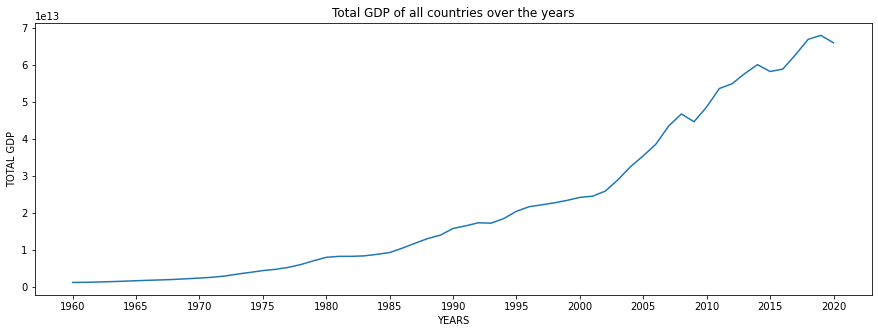

In [12]:
from matplotlib import pyplot as plt

years = pd.Series(count_in_each_year.index)
total_gdp_per_yr = pd.Series(filtered_all_gdp_df.groupby('year')['gdp'].sum())
plt.figure(figsize=(15,5))
plt.title("Total GDP of all countries over the years")
plt.xlabel("YEARS")
plt.ylabel("TOTAL GDP")
#changing the scale of x-axis to 5 years range.
plt.xticks(range(min(years), max(years)+1, 5))
plt.plot(years, total_gdp_per_yr)

**B. Top ten countries in 2020**

<BarContainer object of 10 artists>

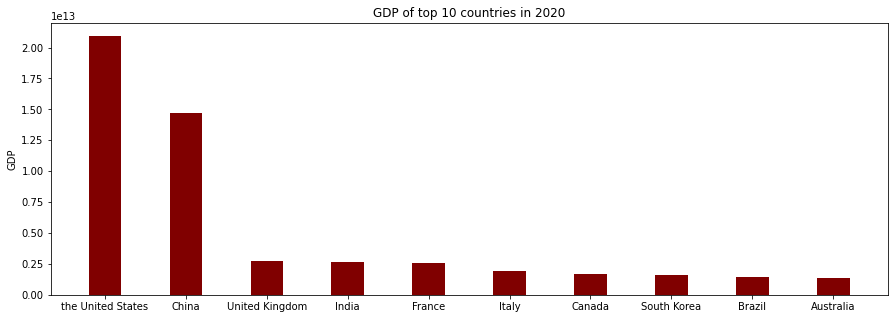

In [13]:
top_5_df = filtered_all_gdp_df.where(filtered_all_gdp_df.year==2020).dropna().head(10)
#no need to sort as the dataframe is already sorted by rank.
# print(top_5_df)
#plotting bar plot
country = top_5_df.loc[:, 'country']
gdp = top_5_df.loc[:, 'gdp']
plt.figure(figsize=(15,5))
plt.title("GDP of top 10 countries in 2020")
plt.ylabel('GDP')
plt.bar(country, gdp, color ='maroon',width = 0.4)


****